In [1]:
%matplotlib inline
import arviz as az
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy import stats

In [2]:
az.style.use('arviz-white')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});


##### <center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Análisis exploratorio de modelos Bayesianos</h1> 
<h2 align="center">Diagnóstico del muestreo</h2> 



<br>
<br>
<br>
<br>
<br>

## ArviZ: Análisis exploratorio de modelos Bayesianos

<br>
<br>
<center><img src="img/logo_arviz.png" width=500></center>
<br>

* Diagnosticar la calidad de la inferencia
* <font color = "gray"> Criticar a los modelos, incluyendo la evaluación de los supuestos del modelo y de sus predicciones </font>
* <font color = "gray">Comparación de modelos, incluyendo la selección y promediado de modelos </font>
* <font color = "gray">Preparar los resultados para una audiencia particular </font>

## Calcular la distribución a posteriori

* Hay muchas formas de calcular una posterior
     * <font color = gray> Conjugación </font>
     * <font color = gray> Método de Laplace </font>
     * <font color = gray> Aproximación de Laplace Anidada Integrada (INLA) </font>
     * <font color = gray> Inferencia Variacional (VI) </font>
     * Markov Chain Monte Carlo (MCMC)
     * ...


* Solo los métodos MCMC (y en menor grado VI) son suficientemente generales


* Restringiremos nuestra discusión actual a los métodos MCMC

## Cadena Markov Monte Carlo (MCMC)

<br>

* Los métodos MCMC se pueden usar para **muestrear** de distribuciones de probabilidad que son difíciles o imposibles de calcular de forma directa.


* Si se satisfacen algunas condiciones muy generales, tenemos una garantía teórica que los métodos MCMC convergerán asintóticamente a la distribución correcta.


* Debido a que no tenemos garantías para muestras finitas, necesitamos diagnosticar la calidad de las muestras MCMC

## Random Walk Metropolis-$\color{grey}{\text{Hasting}}$

1. Inicialice el valor del parámetro $x$ en $x_i$

2. Elija un nuevo valor de parámetro $x_{i + 1}$, tomando muestras de una distribución fácil de muestrear, como una distribución gaussiana $Q(x_{i + 1} \mid x_i)$.

3. Calcule la probabilidad de aceptar el nuevo valor del parámetro:

$$p_a (x_{i + 1} \mid x_i) = min \left (1, \frac{p(x_{i + 1}) \; 
\color{grey}{Q(x_i \mid x_{i + 1})}} {p(x_i) \; \color{grey}{Q (x_{i + 1} \mid x_i)}} \right)$$

4. Si $p_a \gt R$ donde $R \sim \mathcal{U}(0, 1)$. Guarde el nuevo valor, de lo contrario guarde el valor anterior

5. Iterar desde 2 hasta lograr una cantidad *suficiente* de muestras

In [5]:
IFrame(src='mcmc-demo-master/app.html#RandomWalkMH,banana', width=1200, height=800)

## RWMH adaptativo

* En teoría cualquier distribución de propuesta es útil (si tomaramos infinitas muestras)


*  En la práctica la eficiencia cambia drásticamente con la distribución de propuesta


*  En la práctica conviene ajustar hiperparámetros como la distribución de propuesta para cada problema.
    * Esto se puede hacer dedicando una cierta cantidad de pasos (tuning), estos pasos luego se descartan


* Aún el RWMH adaptativo puede tener problemas para ciertas problemas
    * Parámetros muy correlacionados
    * Alta dimensión (muchos parámetros)
    * Geometrías complejas

## Hamiltonian Monte Carlo

<br>

> En vez de proponer nuevos puntos al azar podemos usar una analogía física

<br>

* Simulamos una particula sin fricción que se mueve por la distribución a posteriori


*  Para esto necesitamos dos elementos la energía potencial y la cinética
    * La potencial viene dada por la probabilidad en cada punto del posterior
    * La cinética viene dado por un _empujón que sacado de la galera_

## Hamiltonian Monte Carlo

<br>

* El método tiene varios hyperámetros

* Cuando estos son adecuados el muestreo es muy eficiente (NUTS, HMC dinamico y adaptativo)

<br>


<center><img src="img/HMC_trayectoria.png" width=800></center>


In [6]:
IFrame(src='mcmc-demo-master/app.html#HamiltonianMC,standard', width=1200, height=800)

## Diagnósticos

<br>

 > Asintóticamente los MCMC ofrencen la respuesta correcta <br>
 > Asintóticamente estamos todos muertos!

 <br>


* Es necesario contar con métodos de diagnóstico que permitan evaluar si el muestreo es correcto

* El diagnóstico puede ser difícil
    * Solo podemos recolectar evidencia a favor de la ausencia de problemas
    * Establecer umbrales estrictos suele no tener sentido. Cuantos pelos hay que tener para no ser pelado? 
 

## Diagnósticos
  

* La teoría de MCMC dice que
     * Los puntos de partida no deberían importar
     * El punto actual depende únicamente del punto anterior
     * Una secuencia de muestra no sigue patrón alguno
         * Cada vez que tomamos una muestra deberíamos obtener una muestra diferente, pero deberíamos ser prácticamente indistinguibles unas de otros
         * Para una muestra lo suficientemente larga, la primera porción debe ser indistinguible de la última (y la mismo cualquier otra combinación de regiones).


* Muchos diagnósticos están basados en evaluar si estos resultados teóricos se mantienen
* Además, la mayoría de los paquetes modernos generan automáticamente varias cadenas en paralelo


## Trace plots



* Para cada parámetro graficamos su valor (eje-y) en cada iteración (eje-x)

* Lo esperable es no ver ningún patrón, solo ruido


<img src=img/trace_single_good_bad.png />

## Trace plots

* En general usamos más de una cadena, deben ser indistinguibles

<img src=img/trace_multiple_good.png />



## Trace plots

<br>

    az.plot_trace()
    

* Por defecto obtenemos el trace y un KDE (para variables continuas) y un histograma (para discretas)

<img src=img/trace_multiple_good_arviz.png />


## Rank plot 


> Histogramas de muestras *rankeadas*. El ranking se hace para todas las cadenas juntas, pero se grafica para cada cadena por separado.


```
az.plot_trace(idata, kind="rank_bars")
```


* El ranking debería ser uniforme (ninguna cadena tiene que tener valores más altos/bajos/medios/... que las demás)

* Son más nuevos que los trace plot, por lo que aún no son muy populares

<img src=img/rankbar_single_good_bad.png />

## $\hat R$  (R sombrero)

* Lograron las cadenas mezclarse adecuadamente?

* Comparar la varianza *entre* cadenas con la varianza *dentro* de cada cadena.

<center><img src="img/r_hat.png" width=700></center>

<center><img src="img/r_hat.gif" width=700></center>

## $\hat R$  (R sombrero)

<br>

    az.rhat()
    az.summary(⋅)

* Idealmente $\hat R =$1, en la práctica $\hat R \lessapprox 1.01$ son considerados seguros.

* En la primer fase de modelado valores más altos como $\hat R \approx 1.1$ pueden estár bien.


* Puede ser interpretado como la sobre-estimación de la varianza debido al muestreo finito de MCMC. 
    * Si continuamos muestreando infinitamente, la varianza de las muestras se reducirá en un factor de $\hat R$.

## Gráfico de autocorrelación

<br>

     az.plot_autocorr()

* Idealmente, una muestra debe ser independiente e idénticamente distribuida (iid)


* Por definición, las muestras MCMC están correlacionadas


* En la práctica, queremos muestras con baja autocorrelación

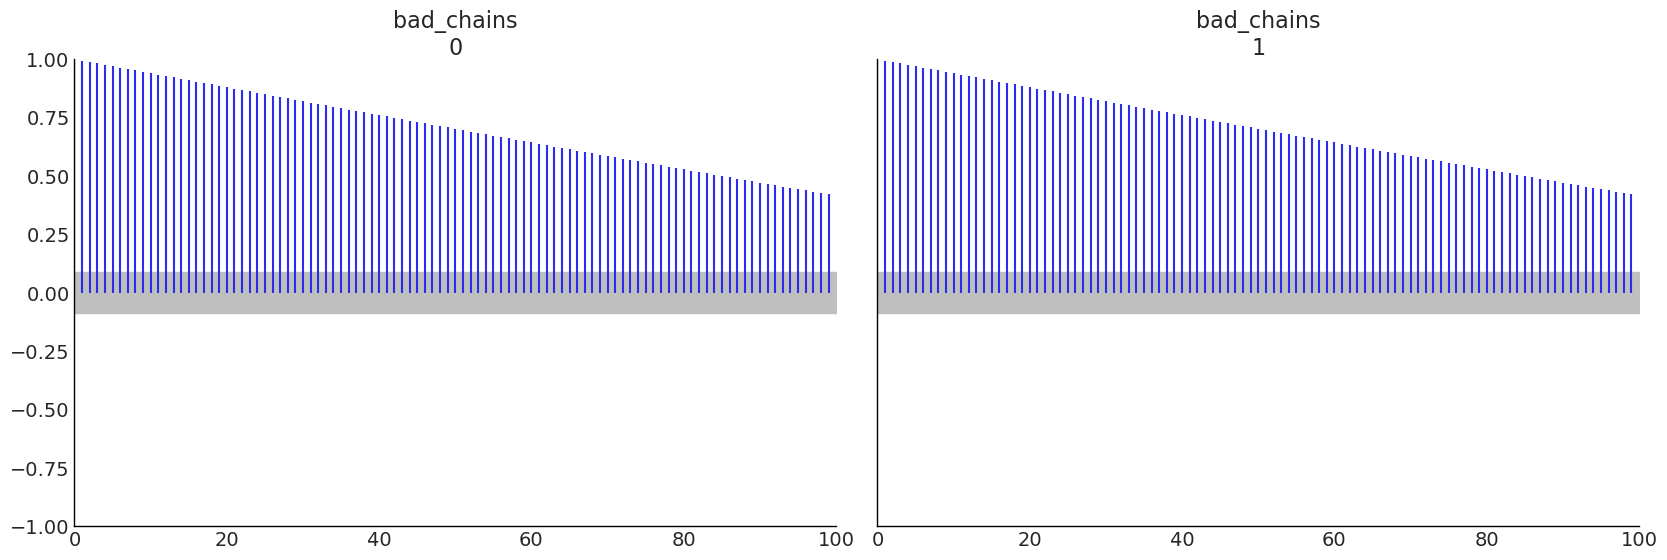

In [7]:
bad_chains = {"bad_chains": np.linspace(0, 1, 1000).reshape(2, -1)}
az.plot_autocorr(bad_chains);

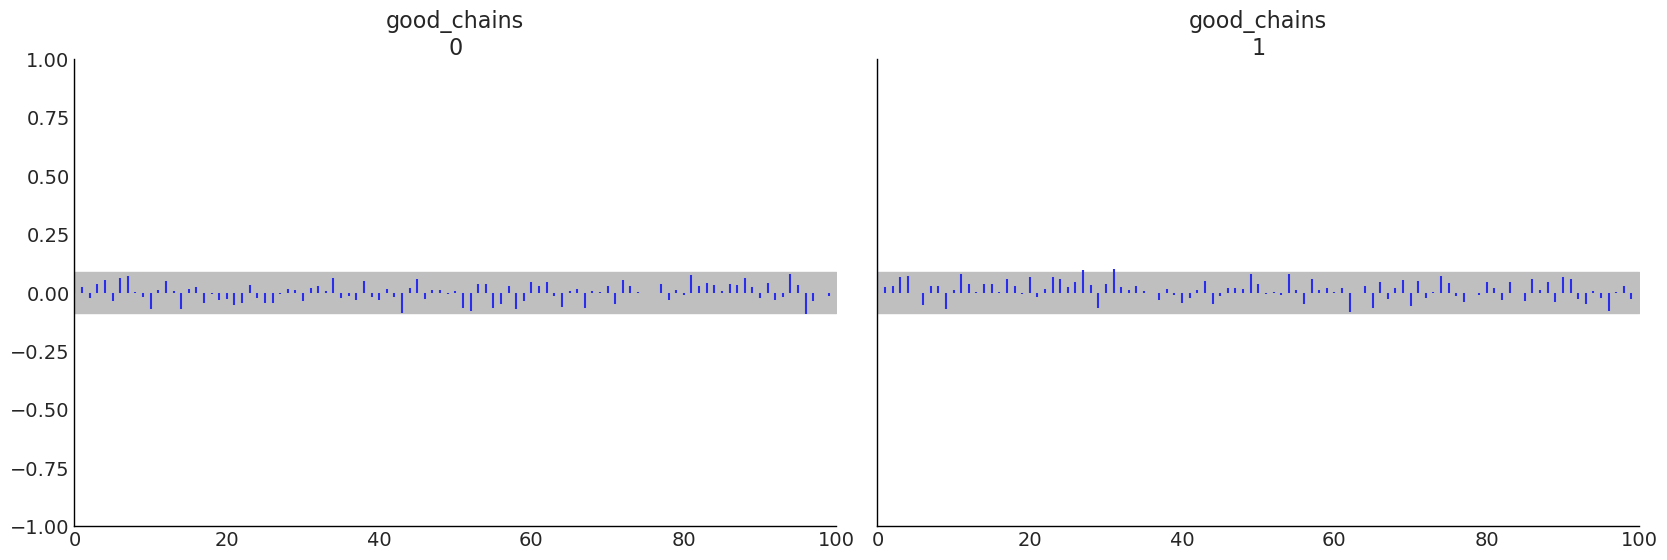

In [8]:
good_chains = {"good_chains": stats.uniform.rvs(0, 1,size=(2,500))}
az.plot_autocorr(good_chains);

## Tamaño de muestra efectivo (ESS)


<center><img src="img/ess.gif" width=600></center>

## Tamaño de muestra efectivo (ESS)

<br>

     az.ess (trace)


* Podemos estimar el **tamaño de muestra efectivo**, es decir, el tamaño de una muestra con la cantidad equivalente de información pero sin autocorrelación


* Es la muestra lo suficientemente grande?


* Recomendamos exigir que el ESS sea superior a 100 por cadena (para 4 cadenas 400).

In [9]:
pd.concat((az.ess(bad_chains).to_pandas(),
           az.ess(good_chains).to_pandas()))

bad_chains       2.282878
good_chains    776.715503
dtype: float64

## Tamaño de muestra efectivo (ESS)

<br>

* Distintas regiones del espacio de los parámetros puede tener distinto valor de ESS


* No todas las regiones son muestreadas con la misma eficiencia

In [10]:
pd.concat([az.summary(good_chains, kind="diagnostics"),
           az.summary(bad_chains, kind="diagnostics")])

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
good_chains,0.011,0.008,777.0,857.0,1.00
bad_chains,0.198,0.165,2.0,11.0,3.05


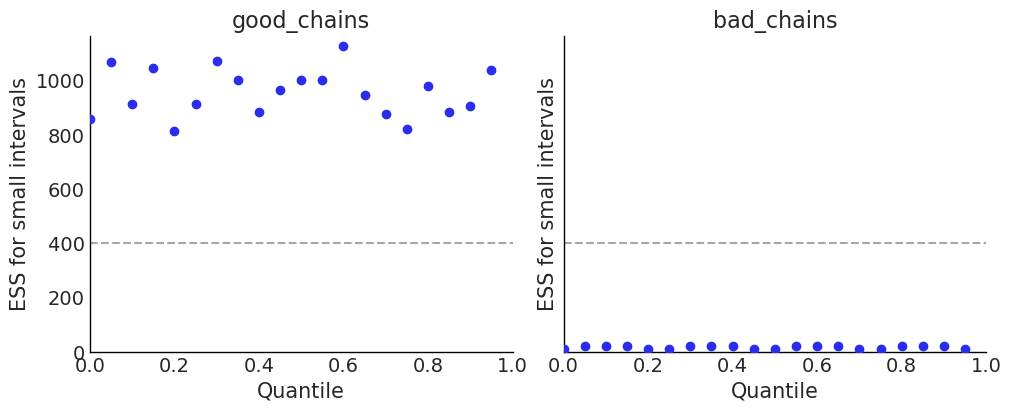

In [11]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(good_chains, ax=axes[0])
az.plot_ess(bad_chains, ax=axes[1]);

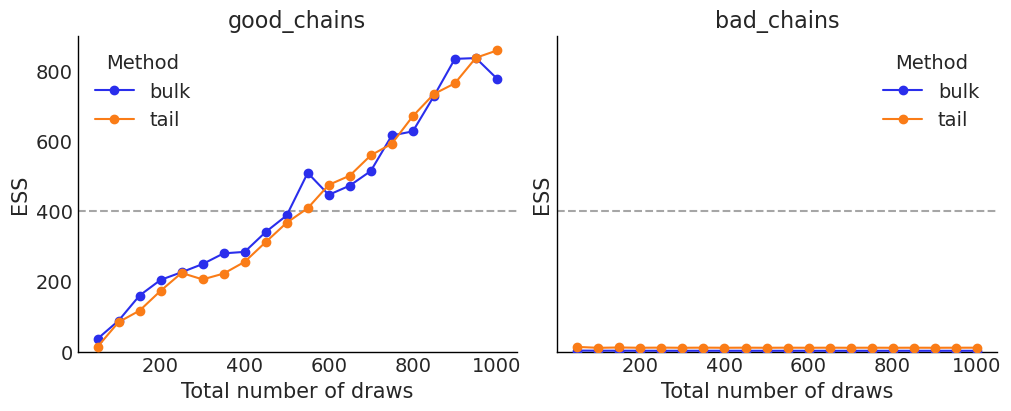

In [12]:
_, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
az.plot_ess(good_chains, kind="evolution", ax=axes[0])
az.plot_ess(bad_chains,  kind="evolution", ax=axes[1]);

# Monte carlo estandard error (mcse)

<br>

* Una de las cantidades devueltas por `summary` es mc_error.


* Esta es una estimación del error introducido por el método de muestreo.


* La estimación tiene en cuenta que las muestras no son realmente independientes entre sí.


* Este error debe estar por debajo de la precisión deseada en nuestros resultados

In [13]:
with pm.Model() as good_model:
    μ = pm.Normal('μ', 0, 1000, shape=2)
    y = pm.Poisson('y', np.exp(μ), observed=[1, 10])
    good_samples = pm.sample(1000)
    
with pm.Model() as bad_model:
    μ = pm.Normal('μ', 0, 1000, shape=2)
    y = pm.Poisson('y', np.exp(μ[0] + μ[1]), observed=[1])
    bad_samples = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


## Diagnóstico de algoritmos basados en gradiente

<br>


* Debido a su funcionamiento interno, algoritmos como NUTS  ofrecen algunas pruebas específicas que no están disponibles para otros métodos


* Generalmente estas pruebas son muy sensibles

In [14]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    idata_cm = pm.sample(2000, random_seed=7)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    bof = pm.Normal('bof', mu=0, sigma=1, shape=10)
    b = pm.Deterministic('b', 0 + bof * a)
    idata_ncm = pm.sample(2000, target_accept=0.9, random_seed=7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bof]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


## Energía de transición vs energía marginal

<br>

* Podemos pensar en un Hamiltoniano MonteCarlo como un proceso de dos pasos
     * Un muestreo determinista (siguiendo el hamiltoniano)
     * Una caminata aleatorio en el espacio del momentum


* Si la distribución de la energía de transición es similar a la distribución de la energía marginal, entonces NUTS es capaz de generar muestras de la distribución marginal de la energía que sean *casi* independientes entre transiciones. 



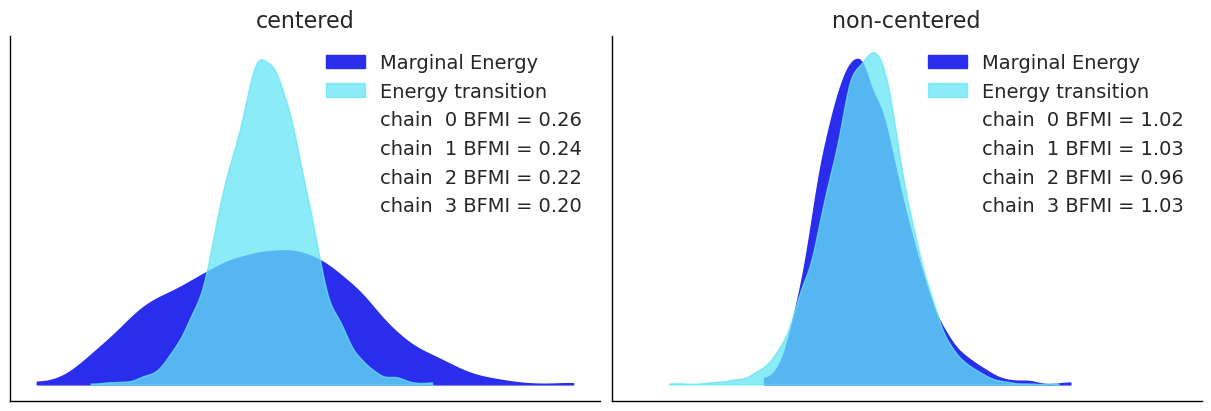

In [15]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4), constrained_layout=True)

for idx, idata in enumerate([idata_cm, idata_ncm]):
    az.plot_energy(idata, ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

## Divergencias

<br>

* Una ventaja de NUTS es que *falla con el estilo*

* Cuando las trayectorias exactas se encuentran en regiones de alta curvatura, las trayectorias numéricas pueden divergir

* Las trayectorias numéricas divergentes son identificadores extremadamente sensibles de *vecindarios patológicos* y, por lo tanto, proporcionan un diagnóstico potente e inmediato.


[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)

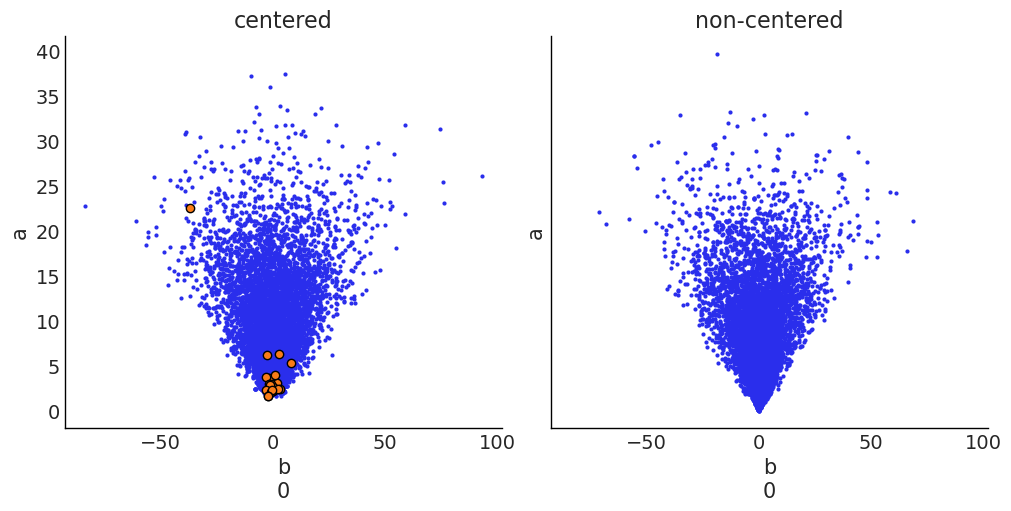

In [16]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, idata in enumerate([idata_cm, idata_ncm]):
    az.plot_pair(idata, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

/home/osvaldo/anaconda3/envs/mol_bayes/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


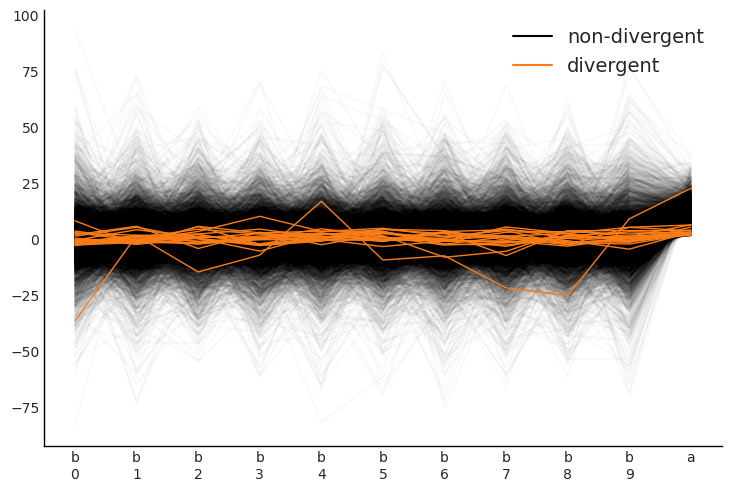

In [17]:
az.plot_parallel(idata_cm);

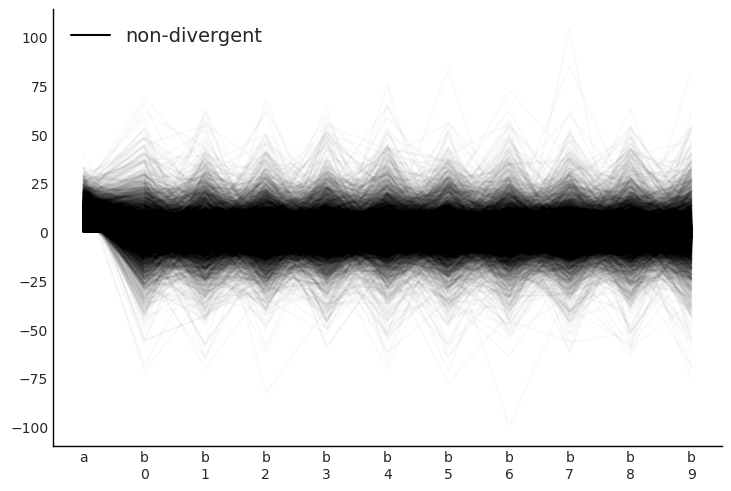

In [18]:
az.plot_parallel(idata_ncm, var_names=['~bof']);

## Qué hacer cuando los diagnósticos no dan bien?

<br>

* <font color = gray> Más muestras o más pasos de tuning (aunque es dificil llegar lejos con esto) </font>

* <font color = gray> Burn-in </font>

* <font color = gray> Cambiar el método de muestreo! </font>


* Reparametrizar el modelo

* <font color = orange> Mejorar los priors </font>
    * El _teorema popular_ de la estadística computacional: Cuando tienes problemas computacionales, a menudo hay un problema con tu modelo.

* En el caso de las divergencias, estan pueden eliminarse aumentando la tasa de aceptación (`pm.sample(..., target_accept=x)` x>0.8)

* Leer los mensajes de advertencia y sugerencias de PyMC!   ;-)

## Para seguir leyendo

[Exploratory Analysis of Bayesian Models](https://github.com/arviz-devs/Exploratory-Analysis-of-Bayesian-Models/tree/master/content) Trabajo en Progreso!


[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)

[Rank-normalization, folding, and localization](https://arxiv.org/abs/1903.08008)